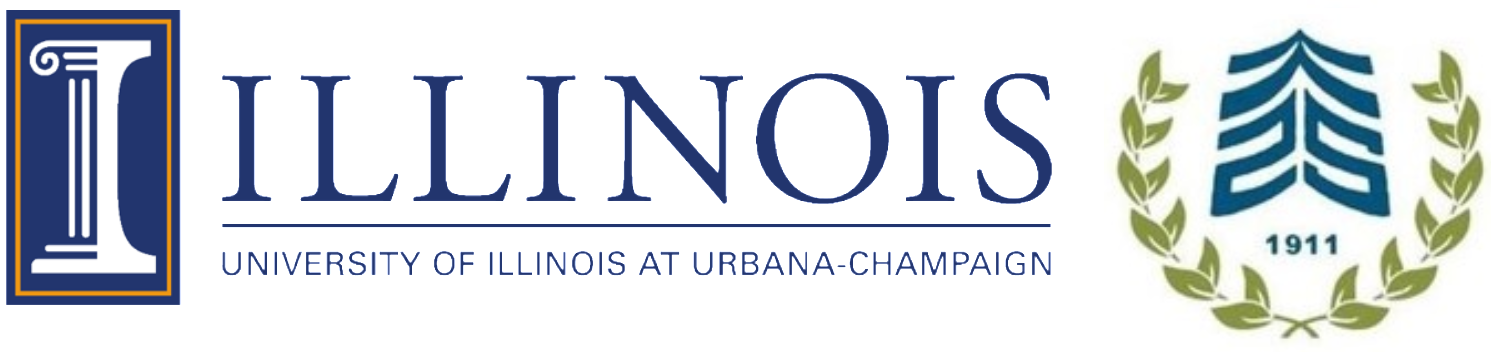


# Geoherb identification based on spectroscopic profiling data and NNRW

Test Subjects

Radix astragali (Astragalus Root; Chinese: huang-qi) is a medicinal herb usually used in
traditional Chinese medicine for the treatment of conditions such as diabetes and cardiovascular diseases

## Data set summary:  

Y labels: ["内蒙黄芪","四川黄芪","山西黄芪","甘肃黄芪"]

<pre>

7044.txt - Raman
  X meaning: Raman shift / wave number
  X range: 100 ~ 4278 cm-1
  Resolution: 2cm-1 

7143.txt - UV
  X meaning: wave length
  X range: 200 ~ 800 nm
  Resolution: 1 nm
</pre>

the origins of these samples were the
Shanxi, Neimenggu, Sichuan, and Gansu provinces of China.
The Raman spectrum of each sample was collected by a portable laser Raman spectrometer ProttezRaman-D3 (Enwave Optronics, USA). The excitation wavelength of the laser was 785 nm and the spectral
measurements were conducted with an exposure time of 5 s and a laser power of 450 mW.
The ultraviolet-visible absorption spectrum of each sample was recorded from a T6 New century ultraviolet-visible spectrometer (Purkinje General Instrument Company Limited, Beijing, China).
Sample preparation. Radix astragali samples were added into a high speed multifunction grinder for
processing for 5–10 min at 25000 rpm. 3 g of the obtained powder sample was added into 30 mL of ethanol
solution, and then the mixture solution was stirred at 100℃ for 60 min under reflux condition. Finally, the
treated sample was cooled naturally and filtered.

<!--
This is a multimodal dataset. 

Multimodality is a universal phenomenon.

In healthcare, physicians use multiple modalities, e.g. MRI, CT, microscope, DNA sequencing, etc. to give a comprehensive judgment.
Another example is self-driving cars, where multiple types of sensors are used, e.g. video cameras, radar, ultrasonic sensors and LIDAR (Laser Imaging Detection and Ranging).
Even in our daily life, we interact with the physical world by multiple senses, i.e. vision, hearing, touching, smelling and tasting. We humans have evolved to process and interpret such multimodel signals as a whole.
The various measuring and photographing instruments have further extended our senses.

Each modality portrays a specific aspect of the physical object.
Based on different physio-chemical principles.
-->

# Install library

We have published relavent codes on GitHub: https://github.com/zhangys11/pyNNRW  
The package is also published on the PyPi repository and can be installed in python via command: ` pip install pyNNRW==0.0.3 `

In [2]:
from pyNNRW import nnrw

### 2D scatter plot

In [3]:
%run plotComponents2D.py

### Visualize feature importance

In [4]:
%run feature_importance.py

# Load Data

In [5]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

FILES = {}
FILES['RAMAN'] = '7044X_RAMAN.csv'
FILES['UV'] = '7143X_UV.csv'

In [6]:
DS = {}

for key in FILES:
    DS[key] = pd.read_csv("ds2/" + FILES[key])
    print(key, DS[key].shape)

RAMAN (160, 2091)
UV (160, 602)


# Preprocessing


## Feature Scaling

Coefficients from LASSO or ElasticNet depend on the magnitude of each variable. It is therefore necessary to rescale, or standardize, the variables.  
The result of centering the variables means that there is no longer an intercept.

Without feature scaling, the feature selection result can be quite different!

## Feature selection via ElasticNet  

1. Reduce dimension and remove unrelavent features for the classification problem
2. reduce the overfitting risk of successive classification model. Improve the generalization
3. By selecting only a few bunch of features, easier to interpret its chemcial meansings. i.e. gain a better understanding of the features and easy to notice  the co-ocurrance of multiple variables (important for Raman, as one bond or molecule have muliptle peaks).

Highly recommendated for Raman, as well as other high-dimensional physio-chemical spectroscopic data, such as MALDI-TOF.

## Feature Selection for Multi-Class

[Evaluating Feature Selection Methods for
Multi-Label Text Classification, by Newton Spolaˆor1 and Grigorios Tsoumakas2]

"Rank features according to the average or the maximum Chi-squared score across all labels, led to most of the best classifiers while using less features."

## Data fusion by concatenating selected feature vectors 

Use `hstack` to get the combined feature vector `Xcmb`

########## RAMAN ###########


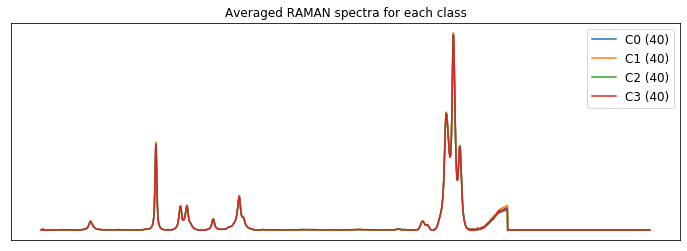

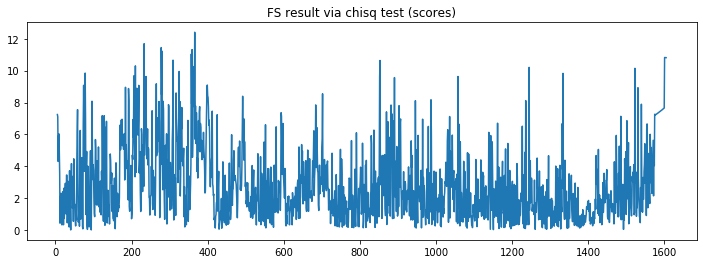

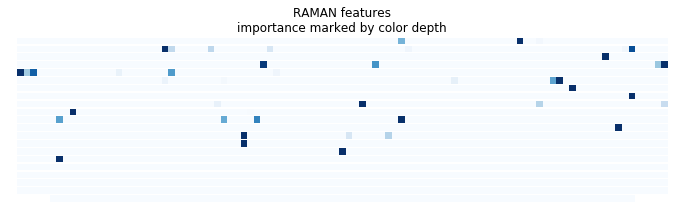

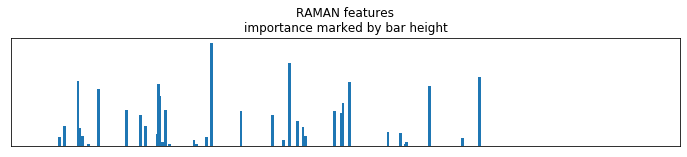

Selected Features (N = 48 ):  ['1264' '1804' '3112' '344' '2216' '900' '2768' '486' '1262' '898' '904'
 '2172' '678' '946' '2112' '1468' '896' '2162' '774' '1686' '1858' '902'
 '808' '252' '1896' '358' '346' '2482' '2568' '894' '376' '1916' '216'
 '1232' '2998' '1144' '1760' '930' '2612' '418' '978' '2600' '484' '1162'
 '258' '906' '1762' '1970']
########## UV ###########


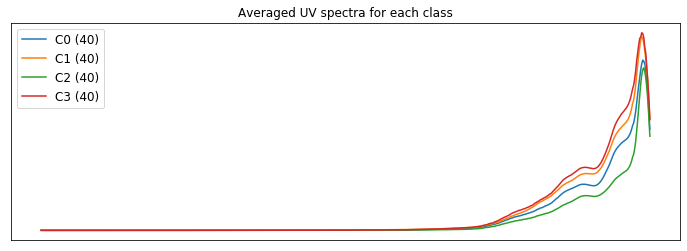

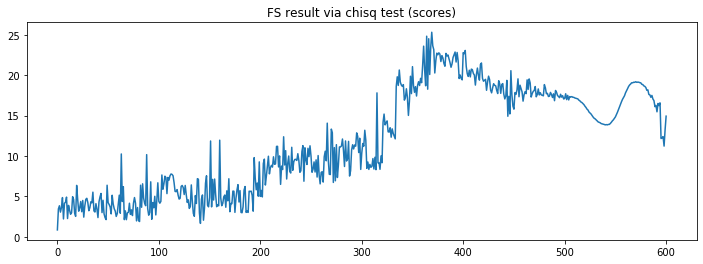

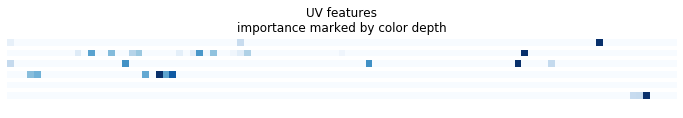

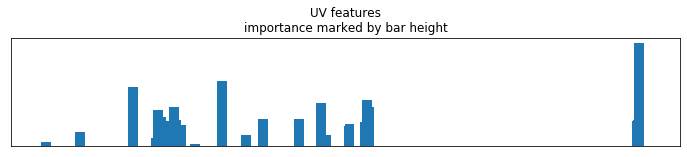

Selected Features (N = 32 ):  ['794' '376' '287' '522' '475' '328' '524' '312' '315' '453' '417' '330'
 '793' '792' '523' '319' '520' '504' '335' '503' '318' '234' '480' '400'
 '310' '334' '327' '325' '200' '349' '333' '329']


In [7]:
dict_metrics = {}
XNAMES = []
XFSNAMES = []
Xcmb = None  # concatenated raw feature vector
ycmb = None
XFS = None # concatenated selected feature vector

for i,key in enumerate(DS):
    
    print('##########', key, '###########')
    
    ds = DS[key]
    # print(ds.describe())
    cols = ds.shape[1]
    
    # convert from pandas dataframe to numpy matrices
    X = np.matrix(ds.iloc[:,1:cols].values)
    y = np.array(ds.iloc[:,0].values.ravel(), dtype='int') # first col is y label
    ys = list(map(str, y))
    X_names = list(ds.columns.values[1:])            

    
    ##############################################
    ####### Plot Averaged Waveform ######
    ##############################################
    
    plt.figure(figsize = (12,4))

    for c in set(y):    
        Xc = X[y == c]
        yc = y[y == c]
        
        plt.plot(X_names, np.mean(Xc,axis=0).T, label= 'C' + str(c) + ' (' + str(len(yc)) + ')') 
        plt.legend(fontsize=12)
        
        cur_axes = plt.gca()
        cur_axes.axes.get_xaxis().set_visible(False) #.set_ticklabels([])
        cur_axes.axes.get_yaxis().set_visible(False) #.set_ticklabels([])

    plt.title(u'Averaged ' + key + ' spectra for each class')
    # plt.title(key, fontsize = 18)
    plt.show()    
    
    
    ##############################################
    ####### Preprocessing - Scaling ######
    # ! Required for feature selection (compare coefficient)
    ##############################################
    
    from sklearn.preprocessing import StandardScaler, MinMaxScaler

    scaler = StandardScaler()
    scaler.fit(X)
    X_scaled = scaler.transform(X)
        
    ##############################################
    ####### Feature Selection. ElasticNet ######
    ##############################################
    from sklearn.linear_model import ElasticNetCV
    from sklearn.feature_selection import chi2, SelectKBest

    mm = MinMaxScaler()
    X_mm = mm.fit_transform(X)
    selector = SelectKBest(chi2, k='all')
    selector.fit(X_mm, ys)
    plt.figure(figsize = (12,4))
    plt.title("FS result via chisq test (scores)")
    plt.plot(selector.scores_)
    plt.show()
   
    elastic_net = ElasticNetCV(cv = 5, tol = 0.005 
                               , alphas = [0.1])
                               # , l1_ratio = 1) # if we want more sparse result
    elastic_net.fit(X_scaled,ys)# NOTE: pass ys not y, to guarantee it is treated as multi-class, not regression
    N = np.count_nonzero(elastic_net.coef_)
    
    biggest_elastic_net_fs = (np.argsort(np.abs(elastic_net.coef_))[-N:])[::-1] # take last N item indices and reverse (ord desc)
    xfs = X_scaled[:,biggest_elastic_net_fs[0:N]] # 前N个系数 non-zero    
    plot_feature_importance(np.abs(elastic_net.coef_), key + " features")
    
    XNAMES = XNAMES + ([key + '_' + s for s in X_names])    
    xfsnames = np.array(X_names)[biggest_elastic_net_fs] 
        
    if (i == 0):
        Xcmb = X
        ycmb = y
        XFS = xfs
    else:
        Xcmb = np.hstack((Xcmb, X))
        assert np.allclose(ycmb, y)
        XFS = np.hstack((XFS, xfs))
        
    XFSNAMES = XFSNAMES + ([key + '_' + s for s in xfsnames])
    
    print("Selected Features (N =", str(N), "): ", xfsnames)

### The reason we use ElasticNet:  
1. elastic net uses L1 regularization, which can produce high level of sparsity. Other FS methods usually produce dense result (e.g., the chisq FS result, as shown above).  
2. elastic net combines both L1 and L2 regularization. It is more versatile and flexible than the pure L1 LASSO.

## 原始拼接向量  concatenated raw feature vector

In [8]:
Xcmb.shape, ycmb.shape, len(XNAMES)

((160, 2691), (160,), 2691)

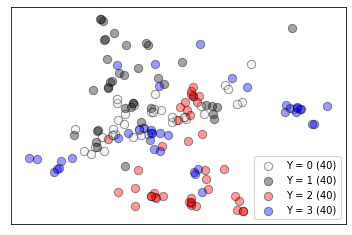

In [9]:
N = Xcmb.shape[1]
from sklearn.decomposition import PCA
Xcmb_pca = PCA(n_components = min(2, N)).fit_transform(Xcmb)
plotComponents2D(Xcmb_pca, ycmb, set(y), ax = None)
plt.legend()

## 关键特征的拼接向量 concatenated selected feature vector

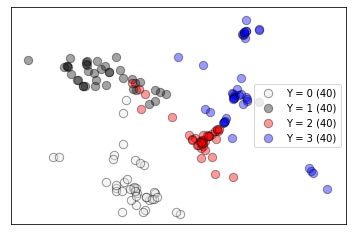

In [10]:
N = XFS.shape[1]
from sklearn.decomposition import PCA
XFS_pca = PCA(n_components = min(2, N)).fit_transform(XFS)
plotComponents2D(XFS_pca, ycmb, set(y), ax = None)
plt.legend()

# Persist the intermediate objects

# 直接加载预处理后的数据

In [11]:
import pickle
with open('fusion_data.pkl', 'rb') as f:
    dic = pickle.load(f)
    
dic.keys()

dict_keys(['Xcmb', 'Xcmb_names', 'Xfs', 'Xfs_names', 'y'])

In [12]:
Xcmb = dic['Xcmb']
XNAMES = dic['Xcmb_names']
XFS = dic['Xfs']
XFSNAMES = dic['Xfs_names']
ycmb = dic['y']

# Performance comparison. Define a wrapper (use callback function parameter), which calls each specific classifier

Due to inherent randomness (e.g., random initialization), some algorithms (e.g., NNRW, MLP) have slightly different results for each run. 

# A. NNRW on the combined feature  

Refer to: `py/keras/1. ANN/ELM.ipynb`

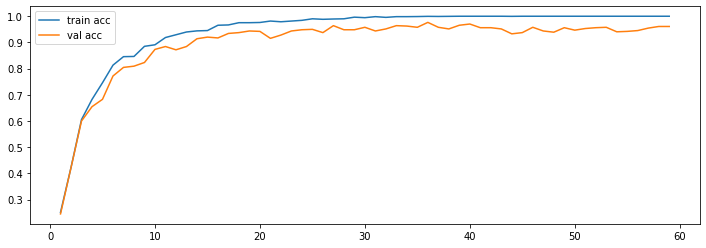

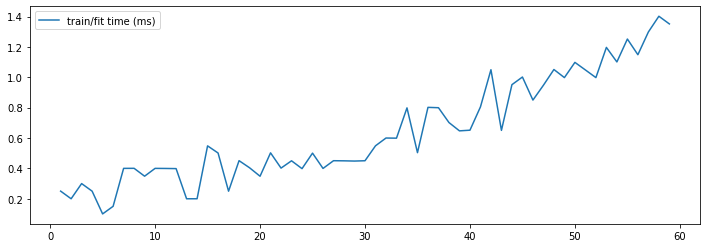

In [14]:
MTacc, MVacc, MT = nnrw.PerformenceTests(nnrw.ELMClf, XFS, ycmb, Ls = list(range(1, 60)))

In [16]:
IDX = 30
print('Mean Train Acc = ', MTacc[IDX], ' Mean Test Acc = ', MVacc[IDX], ' Mean Consumed Time = ', MT[IDX])

Mean Train Acc =  0.996484375  Mean Test Acc =  0.9578125  Mean Consumed Time =  0.69869


# B. MLP

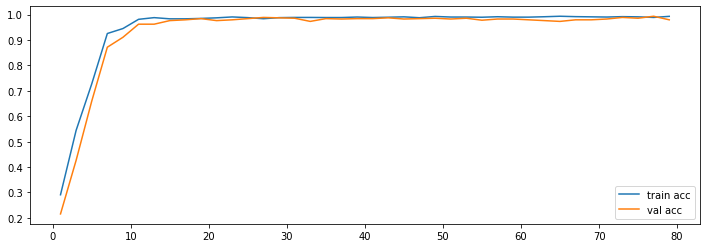

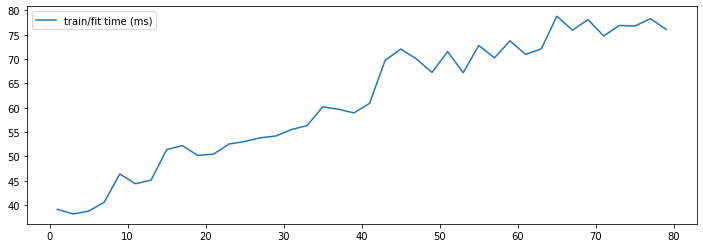

In [15]:
MTacc, MVacc, MT = nnrw.PerformenceTests(nnrw.MLPClf, XFS, ycmb, Ls = list(range(1, 80, 2)))

In [16]:
IDX = 20
print('Mean Train Acc = ', MTacc[IDX], ' Mean Test Acc = ', MVacc[IDX], ' Mean Consumed Time = ', MT[IDX])

Mean Train Acc =  0.988671875  Mean Test Acc =  0.984375  Mean Consumed Time =  60.90045500000001


# C. rbf-SVM

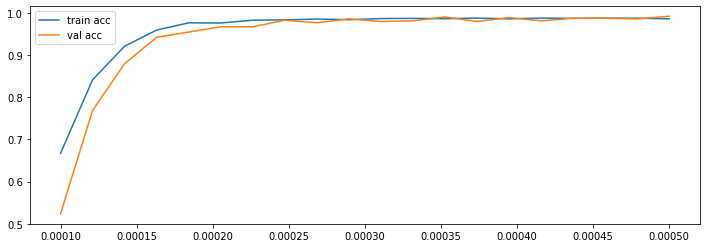

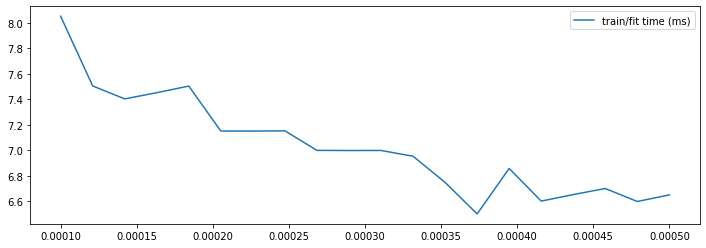

gamma = 1/(2σ^2)


In [17]:
MTacc, MVacc, MT = nnrw.PerformenceTests(nnrw.SVMClf, XFS, ycmb, Ls = np.linspace(0.0001,0.0005,20).tolist())
print("gamma = 1/(2σ^2)")

In [18]:
IDX = 10 
print('Mean Train Acc = ', MTacc[IDX], ' Mean Test Acc = ', MVacc[IDX], ' Mean Consumed Time = ', MT[IDX])

Mean Train Acc =  0.98671875  Mean Test Acc =  0.9796875  Mean Consumed Time =  6.999395


# D. Decision Tree

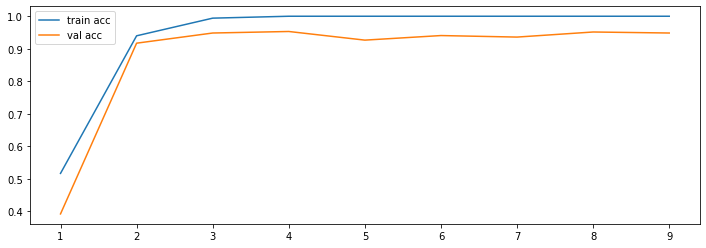

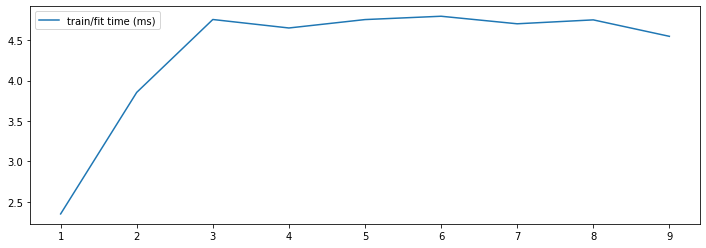

In [19]:
MTacc, MVacc, MT = nnrw.PerformenceTests(nnrw.TreeClf, XFS, ys, Ls = list(range(1,10))) # here we use ys to gurantee it is multi-class, not regression

In [20]:
IDX = 2  # best depth 3
print('Mean Train Acc = ', MTacc[IDX], ' Mean Test Acc = ', MVacc[IDX], ' Mean Consumed Time = ', MT[IDX])

Mean Train Acc =  0.994140625  Mean Test Acc =  0.9484375  Mean Consumed Time =  4.754755


# Appendix

### Raman Interpretation

<table>
    <thead>
        <tr class="text-center">
            <th>Wavenumber (cm-1)</th>
            <th>Raman Shift Interpretation</th>
        </tr>
    </thead>
    <tbody><tr>
                <td>1748</td>
                <td>C=O伸缩振动，主要可能源自于脂肪有关的酯基</td>
            </tr>
            <tr>
                <td>1663</td>
                <td>C=O伸缩振动和C=C伸缩振动，其中C=O伸缩振动可能主要源自于蛋白质的酰胺I键，C=C伸缩振动主要源自于不饱和脂肪酸</td>
            </tr>
            <tr>
                <td>1465</td>
                <td>CH2变形振动，可能主要源自于糖类和脂肪分子</td>
            </tr>
            <tr>
                <td>1337</td>
                <td>糖类的C-H变形振动、C-O伸缩振动或/和游离胆固醇的C-C伸缩振动</td>
            </tr>
            <tr>
                <td>1304/1260</td>
                <td>糖类以及饱和脂肪酸的CH2扭曲振动</td>
            </tr>
            <tr>
                <td>1130</td>
                <td>饱和脂肪酸的C-C伸缩振动或/和糖类的C-C伸缩振动、C-O伸缩振动以及C-O-H变形振动</td>
            </tr>
            <tr>
                <td>1080</td>
                <td>游离胆固醇的C-C伸缩振动或/和糖类的C-C伸缩振动、C-O伸缩振动以及C-O-H变形振动</td>
            </tr>
            <tr>
                <td>930</td>
                <td>胆固醇或/和糖类的C-O-C变形振动、C-O-H变形振动和C-O伸缩振动</td>
            </tr>
            <tr>
                <td>862</td>
                <td>糖类的C-C-H变形振动和C-O-C变形振动</td>
            </tr>
            <tr>
                <td>777</td>
                <td>C-C-O变形振动</td>
            </tr>
            <tr>
                <td>719</td>
                <td>C-S伸缩振动</td>
            </tr>
            <tr>
                <td>652</td>
                <td>C-C-O变形振动</td>
            </tr>
            <tr>
                <td>591/573</td>
                <td>C-C-C变形振动、C-O扭曲振动</td>
            </tr>
            <tr>
                <td>518</td>
                <td>葡萄糖</td>
            </tr>
            <tr>
                <td>484/427/363</td>
                <td>C-C-C变形振动、C-O扭曲振动</td>
            </tr>
    
</tbody></table>


<div class="alert alert-info">    
    <a class="fa fa-book" href="~/Assets/Raman bands.pdf">
        <span>Reference (Raman Bands)</span>
    </a>
</div>

### UV Interpretation

<img src="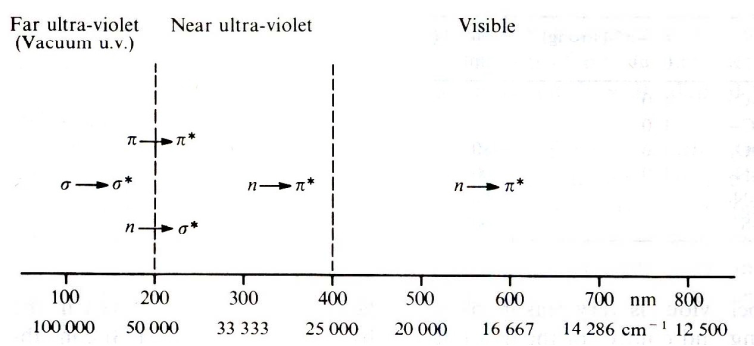
">

<table>
    <thead>
        <tr class="text-center">
            <th>Substance</th>
            <th>Absorption Peak</th>
            <th>Molar Absorption Coefficient</th>
        </tr>
    </thead>
    <tboday>
        <tr class="text-right">
            <td>
                Ethylene(CH2=CH2)<br />
                1.3-butadiene<br />
                Vitamin A<br />
                β-carotene
            </td>
            <td>
                180nm<br />
                217nm<br />
                328nm<br />
                450nm
            </td>
            <td>
                10000<br />
                21000<br />
                51000<br />
                140000
            </td>
        </tr>
        <tr class="text-right">
            <td>
                Benzene<br />
                Naphthalene<br />
                Anthracene<br />
                Naphthacene
            </td>
            <td>
                255nm<br />
                286nm<br />
                375nm<br />
                477nm
            </td>
            <td>
                180<br />
                360<br />
                7100<br />
                110000
            </td>
        </tr>
    </tboday>
</table>

<p>* chromophore: the part of a molecule responsible for its colour.. The colour is caused when a molecule absorbs certain wavelengths of visible light.It transmits or reflects only other wavelengths, which causes the colour we see</p>

<div class="alert alert-info">
    <a target="_blank" class="fa fa-book" href="https://www2.chemistry.msu.edu/faculty/reusch/VirtTxtJml/Spectrpy/UV-Vis/spectrum.htm">
        <span>Reference (Visible and Ultraviolet Spectroscopy)</span>
    </a>
</div>

### Data Science Package Version Info

In [29]:
import sklearn
import numpy
import pandas
import matplotlib
import time
import pkg_resources

print("numpy " + numpy.__version__)
print("pandas " + pandas.__version__)
print("matplotlib " + matplotlib.__version__)

print("NNRW: self-implementation " +  pkg_resources.get_distribution("pyNNRW").version)
print("MLP: sklearn " + sklearn.__version__)
print("SVM: sklearn " + sklearn.__version__)
print("DTC: sklearn " + sklearn.__version__)

numpy 1.18.1
pandas 1.0.1
matplotlib 3.1.3
NNRW: self-implementation 0.1.7
MLP: sklearn 0.22.1
SVM: sklearn 0.22.1
DTC: sklearn 0.22.1


<hr/>

<div style="height: 600px"></div>

## 对比融合前/后 Compare classification before/after data fusion

########## RAMAN ###########
XFS dim:  48


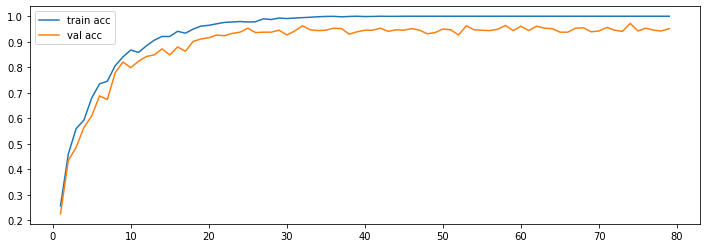

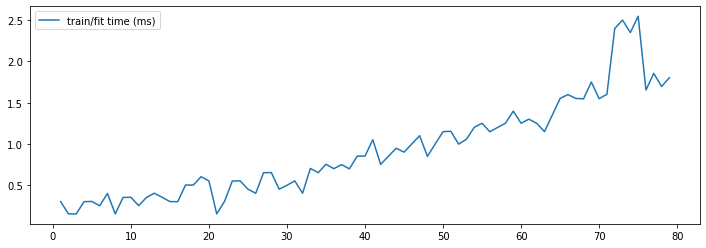

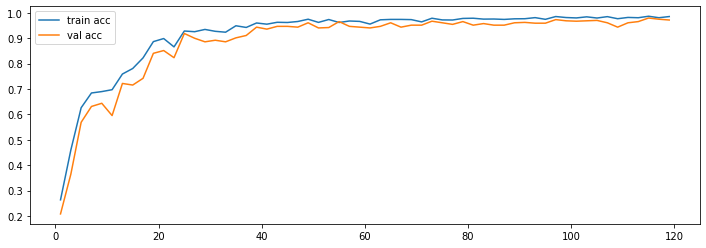

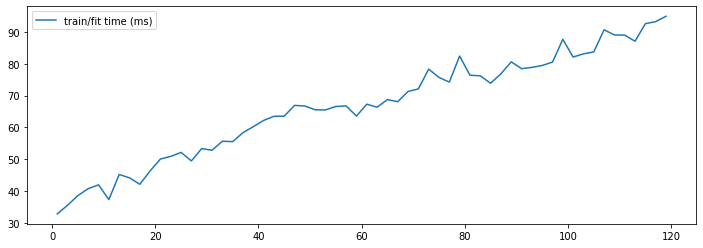

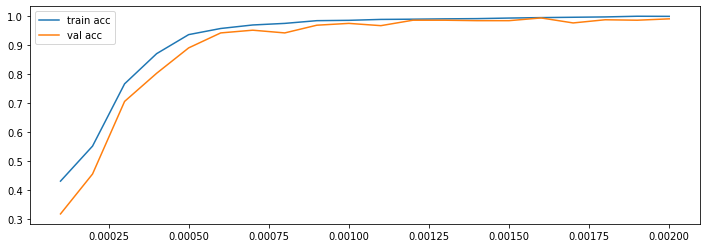

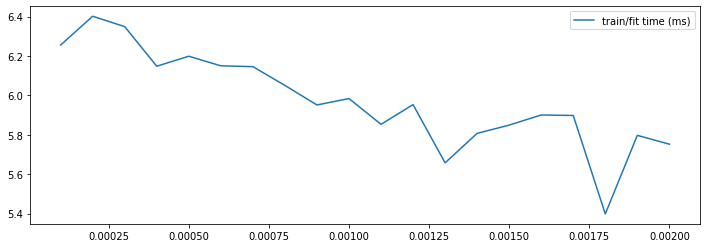

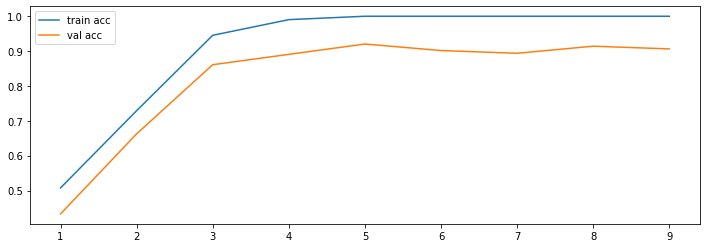

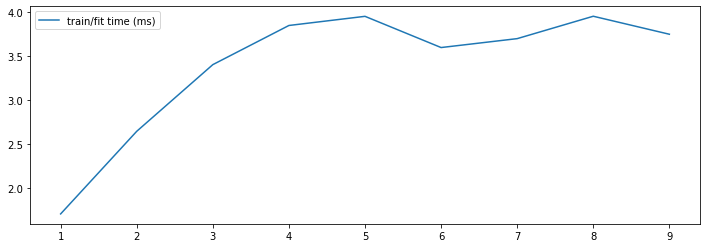

########## UV ###########
XFS dim:  32


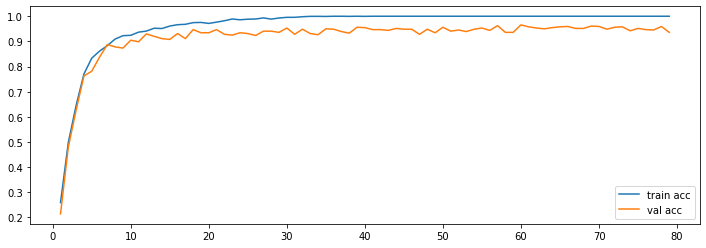

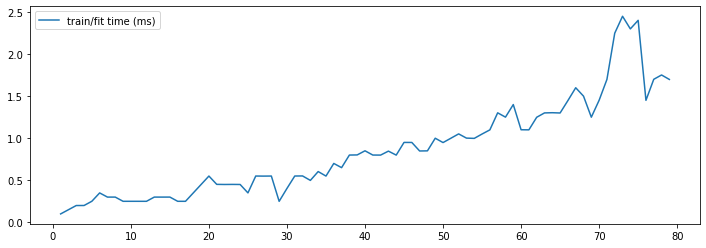

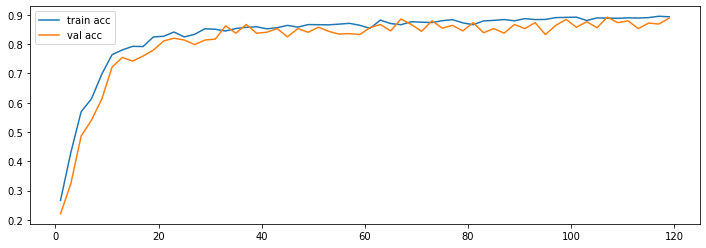

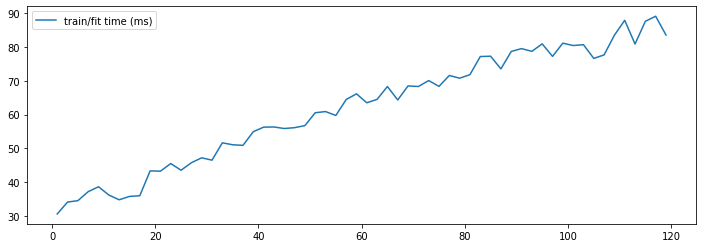

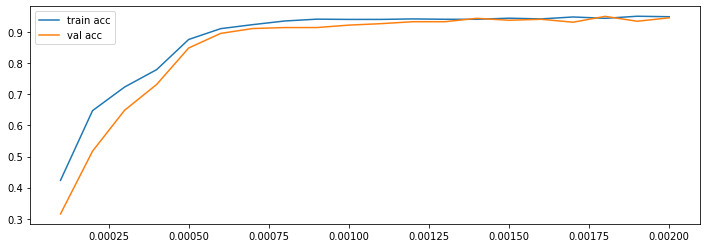

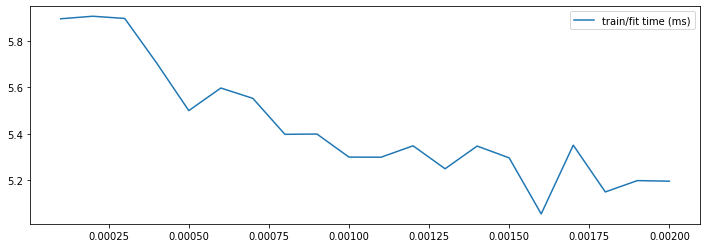

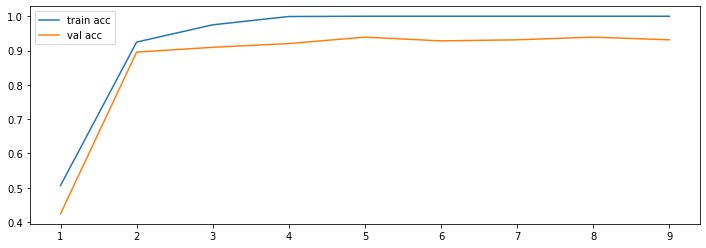

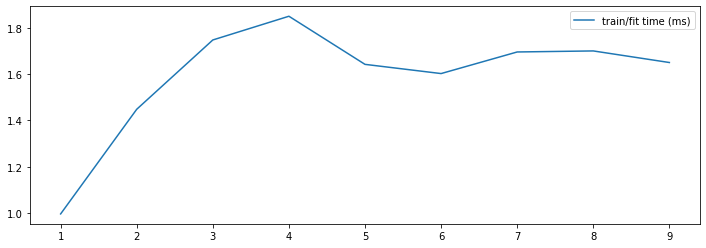

In [30]:
dicts = {}

for i,key in enumerate(DS):
    
    dic = {}
    
    print('##########', key, '###########')
    
    ds = DS[key]
    cols = ds.shape[1]
    
    # convert from pandas dataframe to numpy matrices
    X = np.matrix(ds.iloc[:,1:cols].values)
    y = np.array(ds.iloc[:,0].values.ravel(), dtype='int') # first col is y label
    X_names = list(ds.columns.values[1:])            

    ##############################################
    ####### Preprocessing - Scaling ######
    # ! Required for feature selection (compare coefficient)
    ##############################################
    
    from sklearn.preprocessing import StandardScaler

    scaler = StandardScaler()
    scaler.fit(X)
    X_scaled = scaler.transform(X)
        
    ##############################################
    ####### Feature Selection. ElasticNet ######
    ##############################################
    from sklearn.linear_model import ElasticNetCV
    elastic_net = ElasticNetCV(cv = 5, tol = 0.005 
                               , alphas = [0.1])
                               # , l1_ratio = 1) # if we want more sparse result
    elastic_net.fit(X_scaled,y)
    N = np.count_nonzero(elastic_net.coef_)
    print("XFS dim: ", N)
    biggest_elastic_net_fs = (np.argsort(np.abs(elastic_net.coef_))[-N:])[::-1] # take last N item indices and reverse (ord desc)
    XFS = X_scaled[:,biggest_elastic_net_fs[0:N]] # 前N个系数 non-zero
    
    ##############################################
    ####### Classification ######
    ##############################################
    
    dic['ELM'] = nnrw.PerformenceTests(nnrw.ELMClf, XFS, y, Ls = list(range(1, 80)))
    dic['MLP'] = nnrw.PerformenceTests(nnrw.MLPClf, XFS, y, Ls = list(range(1, 120, 2)))    
    dic['SVM'] = nnrw.PerformenceTests(nnrw.SVMClf, XFS, y, Ls = np.linspace(0.0001,0.002,20).tolist())    
    dic['DTC'] = nnrw.PerformenceTests(nnrw.TreeClf, XFS, y, Ls = list(range(1,10)))    
    dicts[key] = dic

In [31]:
dicts["RAMAN"]["ELM"][1][30], dicts["RAMAN"]["MLP"][1][20], dicts["RAMAN"]["SVM"][1][10], dicts["RAMAN"]["DTC"][1][2]

(0.9421875, 0.9359375, 0.9671875, 0.8609375)

In [32]:
dicts["UV"]["ELM"][1][30], dicts["UV"]["MLP"][1][20], dicts["UV"]["SVM"][1][10], dicts["UV"]["DTC"][1][2]

(0.928125, 0.840625, 0.9265625, 0.909375)

In [33]:
# Using multimodal. The results may vary slightly each time.
0.9578125, 0.984375, 0.978125, 0.940625

(0.9578125, 0.984375, 0.978125, 0.940625)

Data fusion works better than single modality. For NNRW, improved by 1% ~ 2%. For MLP, >4%. For SVC, 0.5% ~ 4%. For DTC, 3% ~ 7%.